All the imports

In [1]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from src.utils.analysis_tools import *


In [2]:
path = "./data/"
filtered_meta = pd.read_csv(path+"final_yt_metadata.csv")

C:\Users\leoga\AppData\Local\Temp\ipykernel_20604\803352734.py:2: DtypeWarning: Columns (4,6,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_meta = pd.read_csv(path+"final_yt_metadata.csv")


12 hours is the limit for livestream uploads


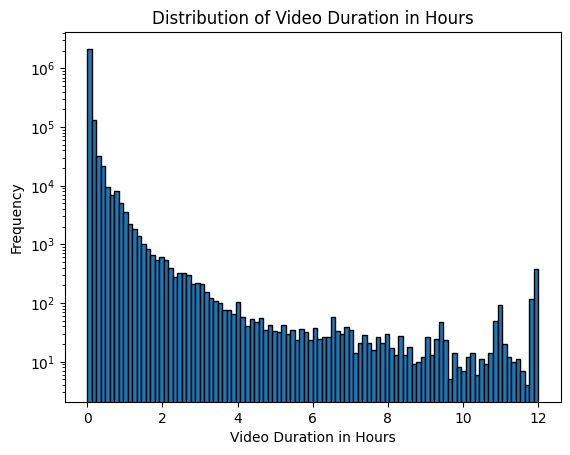

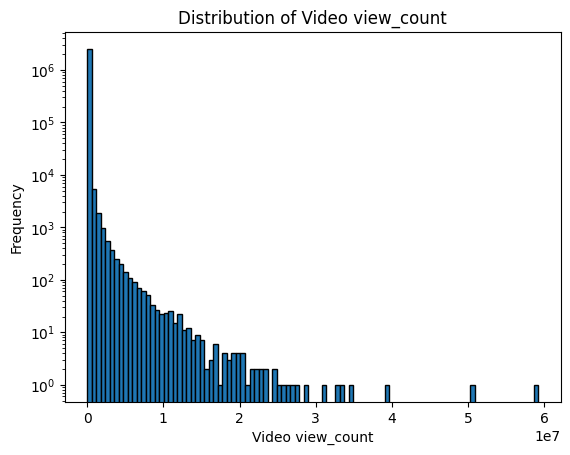

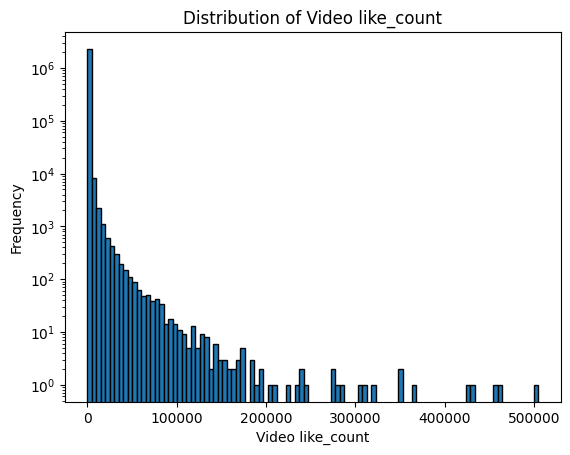

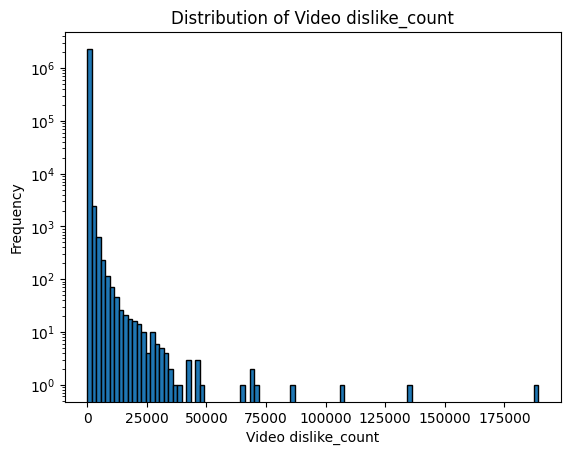

KeyError: "None of [Index([24497, 17096, 13344, 11502, 11240, 10143, 10004,  9938,  9735,  9712,\n       ...\n           1,     1,     1,     1,     1,     1,     1,     1,     1,     1],\n      dtype='int64', length=156883)] are in the [columns]"

In [9]:
plot_video_stat(filtered_meta, 'duration')
plot_video_stat(filtered_meta, 'view_count')
plot_video_stat(filtered_meta, 'like_count')
plot_video_stat(filtered_meta, 'dislike_count')

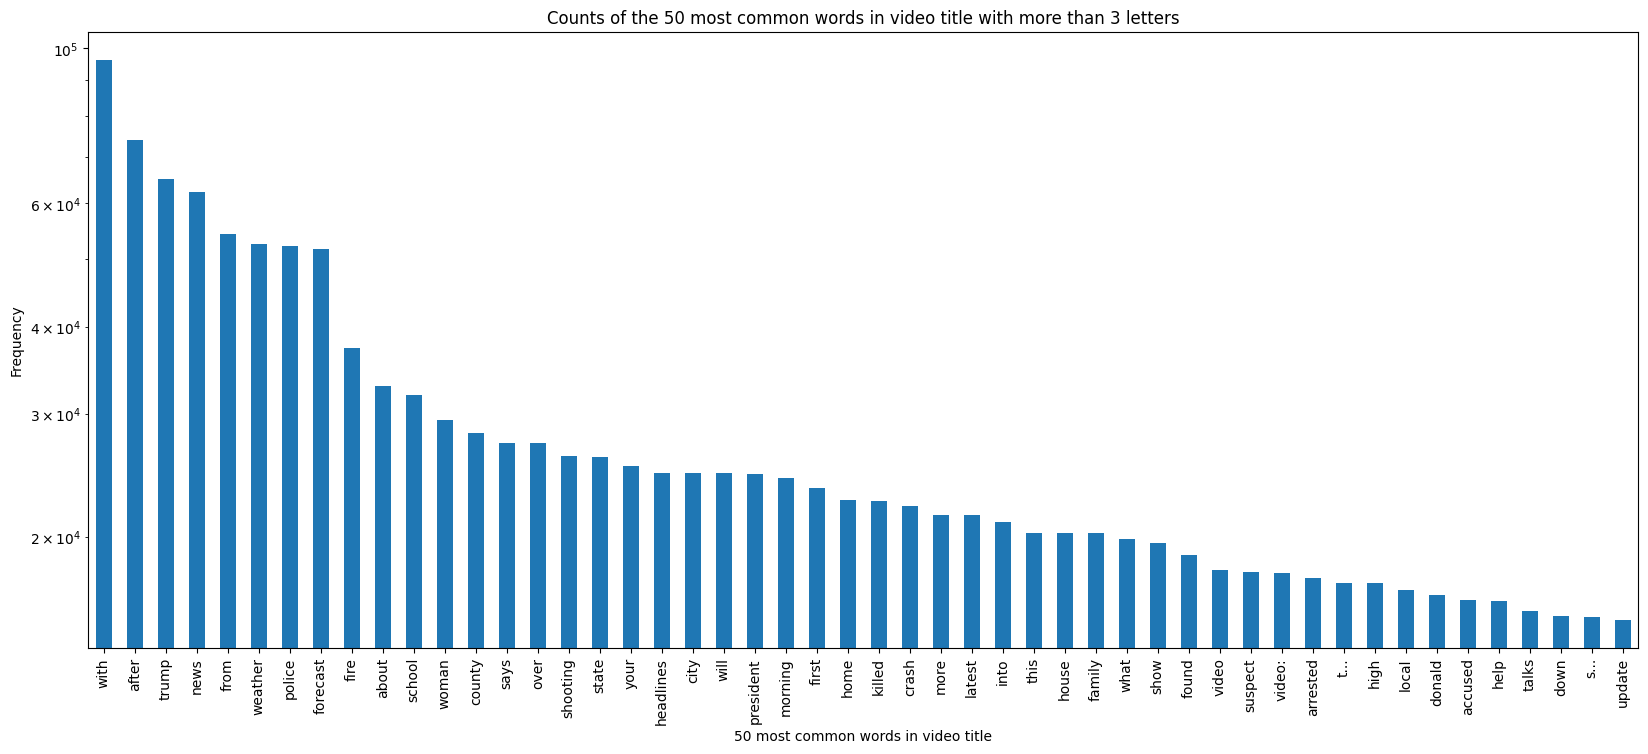

In [4]:
plot_most_common_words(filtered_meta, 'title', 50)


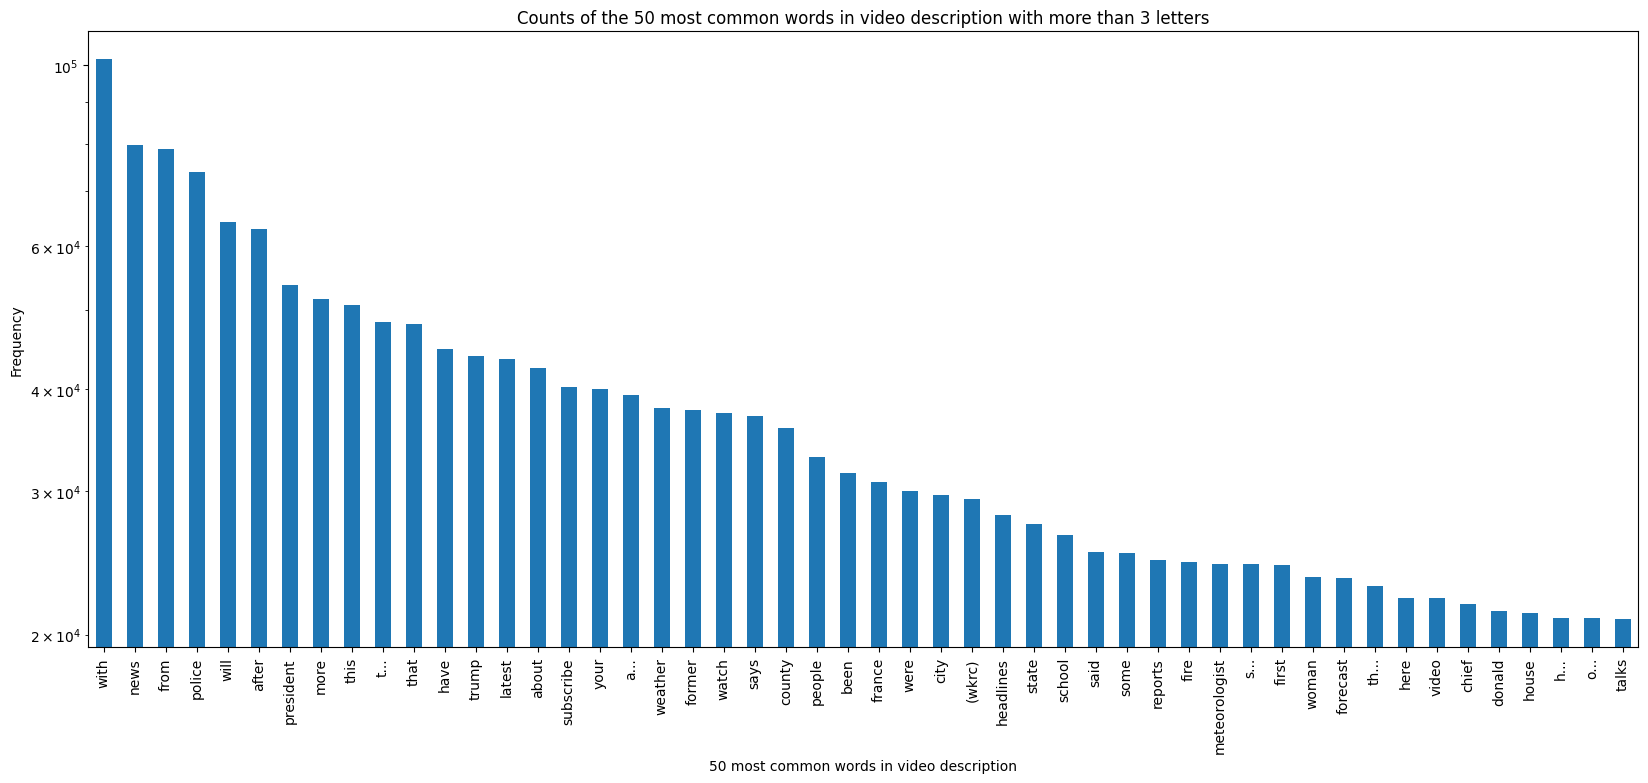

In [5]:
plot_most_common_words(filtered_meta, 'description', 50)

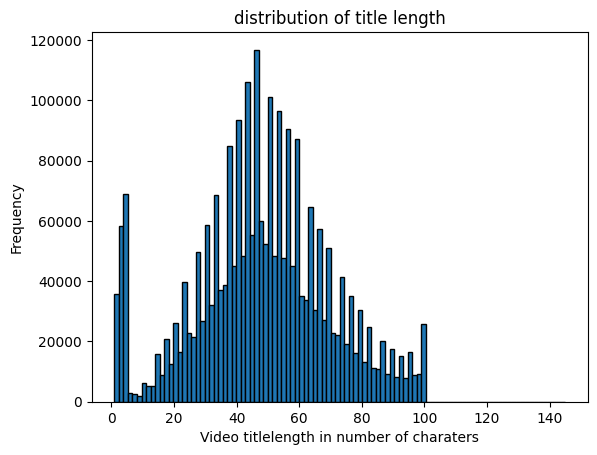

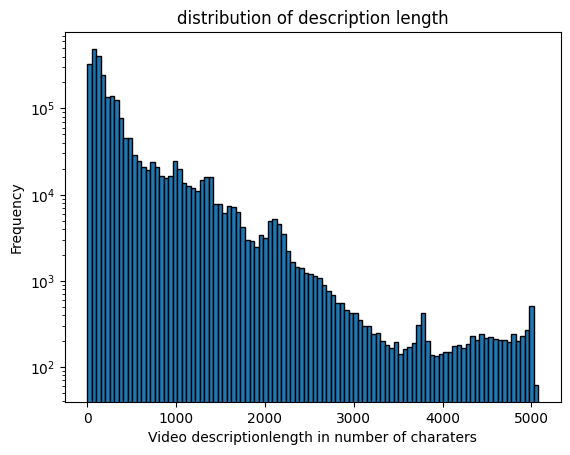

In [6]:
plot_text_len_char(filtered_meta, 'title')
plot_text_len_char(filtered_meta, 'description')

In [221]:
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

ana = SentimentIntensityAnalyzer()

from pattern import sentiment

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\leoga\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


ImportError: cannot import name 'sentiment' from 'pattern' (C:\Users\leoga\AppData\Roaming\Python\Python311\site-packages\pattern\__init__.py)

In [278]:
text = filtered_meta['title'].sample(1).to_string(index=False)
scores = ana.polarity_scores(text)
sent = sentiment(text)
print(text,"| pattern:",sent,  "nltk:", scores)


GOP: Screw Jobs To Hurt Obama In 2012 | pattern: (0.0, 0.0) nltk: {'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.5859}


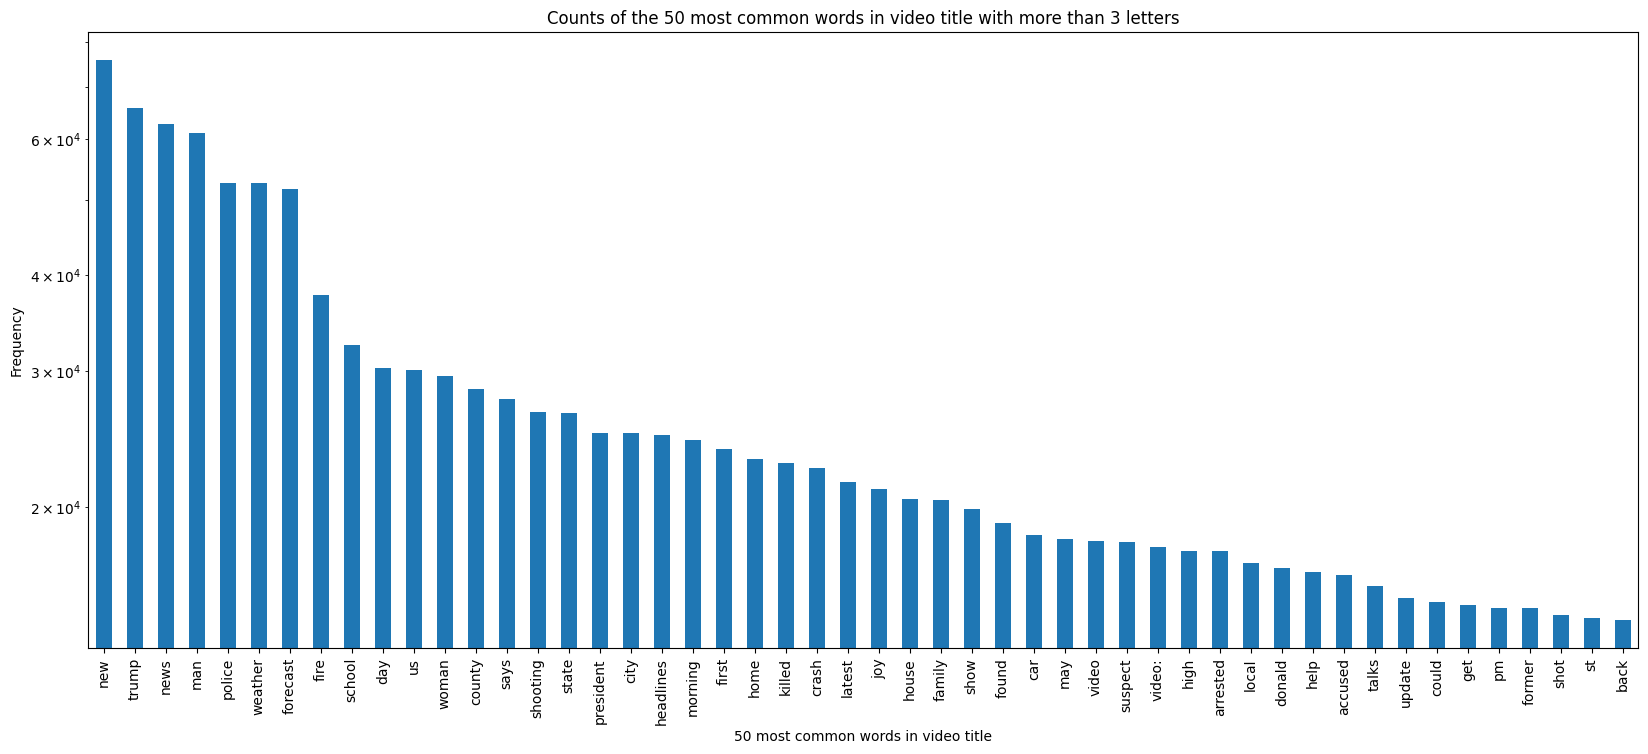

In [153]:
plot_most_common_words(filtered_meta, 'title', 50)


In [157]:
import nltk
nltk.download('sentiment')

[nltk_data] Error loading sentiment: Package 'sentiment' not found in
[nltk_data]     index


False

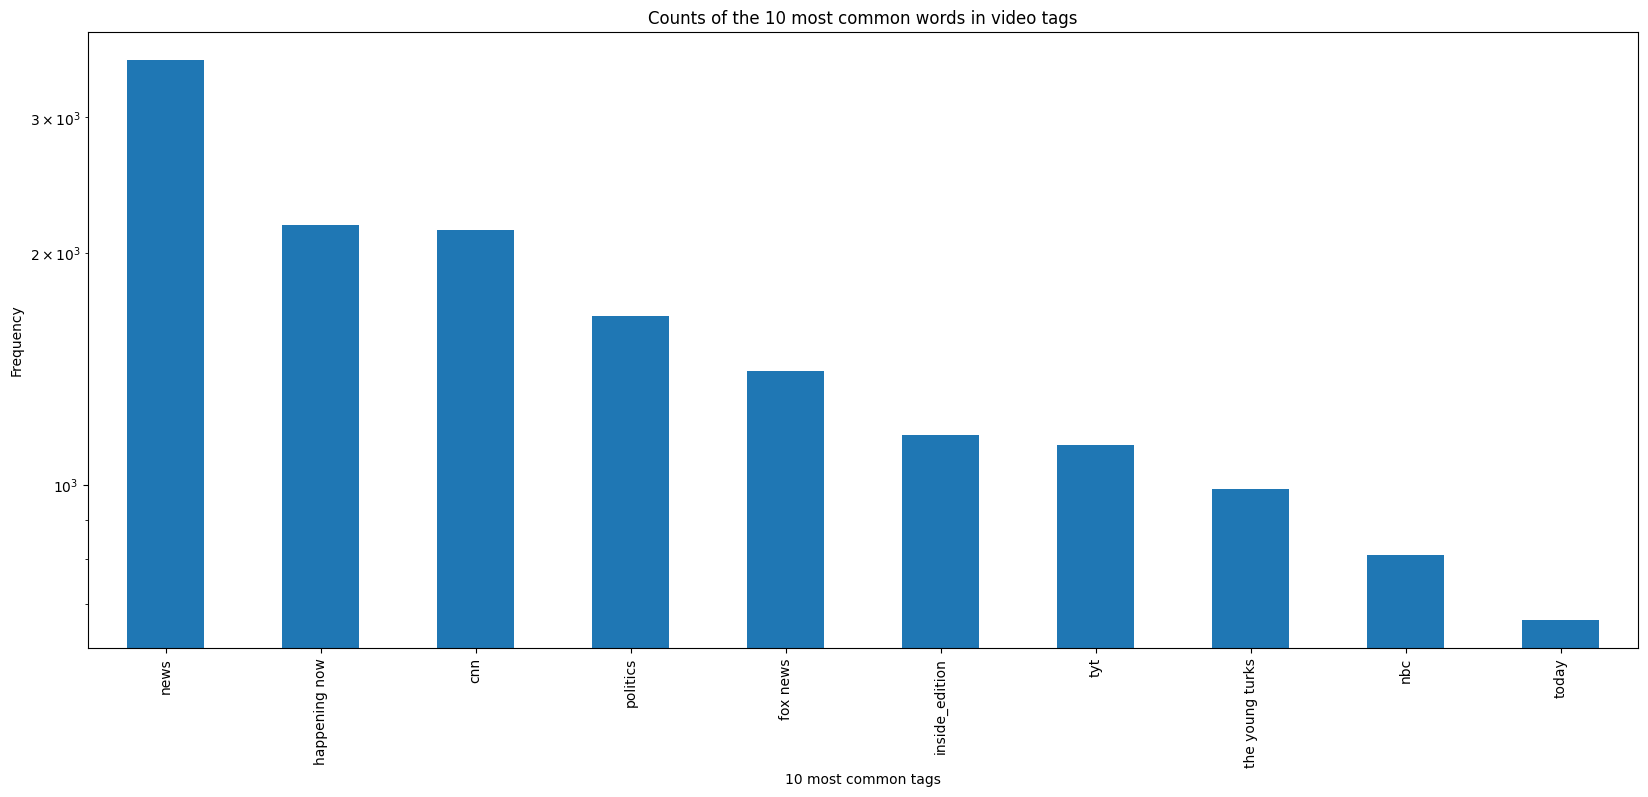

In [38]:
high_likes= highperformer(filtered_meta, 'view_count', 1)
plot_most_common_tags(high_likes, 10)

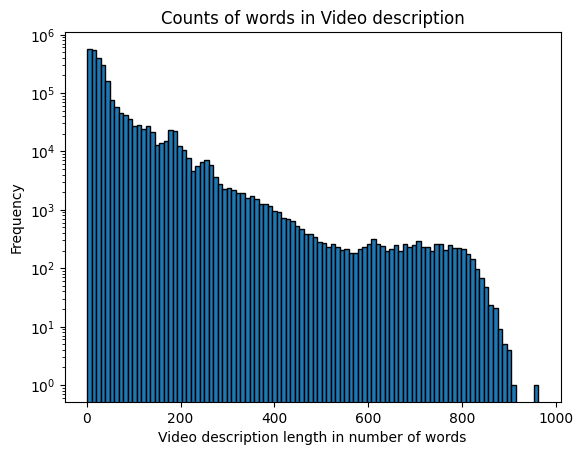

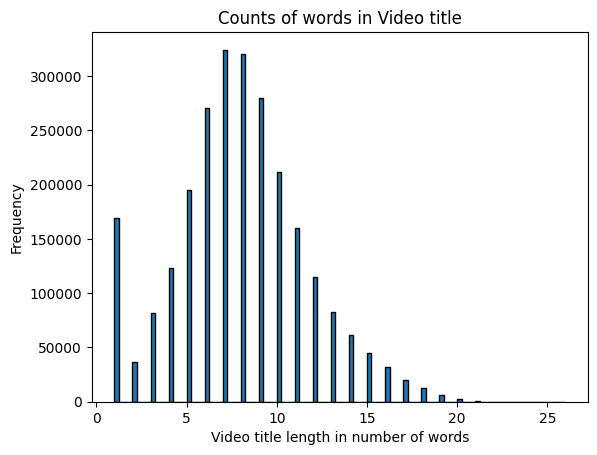

In [46]:
plot_text_len_words(filtered_meta, 'description')
plot_text_len_words(filtered_meta, 'title')

In [286]:

def capitalisation_ratio(text):
    up_count = sum(1 for c in text if c.isupper())
    low_count = sum(1 for c in text if c.islower())
    #handle edge cases
    if low_count == 0:
        return float('inf') if up_count > 0 else 0  
    return up_count / low_count

In [288]:
df = pl.DataFrame({
    "title": ["THIS is a Test", "ALL CAPS", "no caps here", "12345", ""]
})

# Apply the function to the 'title' column using `pl.map`
df = df.with_columns(
    pl.col("title").map_elements(capitalisation_ratio).alias("capitalisation_ratio")
)

# Display the resulting DataFrame
print(df)



shape: (5, 2)
┌────────────────┬──────────────────────┐
│ title          ┆ capitalisation_ratio │
│ ---            ┆ ---                  │
│ str            ┆ f64                  │
╞════════════════╪══════════════════════╡
│ THIS is a Test ┆ 0.833333             │
│ ALL CAPS       ┆ inf                  │
│ no caps here   ┆ 0.0                  │
│ 12345          ┆ 0.0                  │
│                ┆ 0.0                  │
└────────────────┴──────────────────────┘


C:\Users\leoga\AppData\Local\Temp\ipykernel_10800\3235081857.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(


In [282]:
sample = filtered_meta.sample(2)
print(sample)
print(cap_ratio(sample, 'title'))

             categories                channel_id                  crawl_date  \
43574   News & Politics  UCrp_UI8XtuYfpiqluWLD7Lw  2019-11-22 02:13:00.173621   
164499  Travel & Events  UCp1KrVaZDZ7BOI_QBuTWWmg  2019-11-08 18:28:05.711519   

                                              description dislike_count  \
43574   Two U.S. defense officials estimate that Presi...           3.0   
164499  Mar Brettmann, executive director of Business ...           0.0   

         display_id duration  like_count  \
43574   SUUfpkIk3K0      114         6.0   
164499  JIzLrhDqBC4       90         9.0   

                                                     tags  \
43574   Bottom Line,CNBC,business news,finance stock,s...   
164499                                                NaN   

                                                    title  \
43574   Trump’s troop deployment to U.S.-Mexico border...   
164499    The Signs Of Possible Sex Trafficking In Hotels   

                upload_date  